In [1]:
!pip install d2l

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [2]:
import torch
from torch import nn
from d2l import torch as d2l
from IPython import display

In [3]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

实现一个具有单隐藏层的多层感知机，它包含256个隐藏单元

In [4]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(
        torch.randn(num_inputs, num_hiddens, requires_grad=True)
    )
b1 = nn.Parameter(
        torch.zeros(num_hiddens, requires_grad=True)
    )
W2 = nn.Parameter(
        torch.randn(num_hiddens, num_outputs, requires_grad=True)
    )
b2 = nn.Parameter(
        torch.zeros(num_outputs, requires_grad=True)
    )

params = [W1, b1, W2, b2]

实现ReLU激活函数

In [5]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

实现模型

In [6]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X @ W1 + b1)
    return (H @ W2 + b2)

这段代码是一个简单的神经网络前向传播（feedforward）的实现。让我们逐行解释这个代码：

```python
def net(X):
    X = X.reshape((-1, num_inputs))
```
这里定义了一个函数 `net`，它接受一个输入 `X`。在这里，`X` 是一个输入数据的数组。通过 `reshape` 函数，将输入 `X` 重新塑形成一个二维数组，其中第一个维度为 -1，表示该维度的大小由数组的总元素个数和其他维度的大小来自动推断。`num_inputs` 是在代码中未定义的变量，应该是表示输入数据的特征数量。

```python
    H = relu(X @ W1 + b1)
```
接下来，进行第一层的运算。`@` 符号表示矩阵相乘。`W1` 和 `b1` 是在代码中未定义的变量，应该是表示神经网络的第一层的权重矩阵和偏置向量。 `relu` 是一个激活函数，它对矩阵运算的结果进行修正线性单元操作，即对每个元素进行非负性判断，小于零的元素变为零，大于等于零的元素保持不变。

```python
    return (H @ W2 + b2)
```
最后，进行第二层的运算。同样，`W2` 和 `b2` 是在代码中未定义的变量，应该是表示神经网络的第二层的权重矩阵和偏置向量。最终的输出是由第二层的计算得到的。

总的来说，这段代码实现了一个简单的两层神经网络的前向传播过程。首先对输入数据进行形状调整，然后经过第一层的矩阵相乘和激活函数操作，最后通过第二层的矩阵相乘和偏置相加得到最终的输出。这是神经网络中常见的前向传播结构。

In [7]:
loss = nn.CrossEntropyLoss()

训练

In [8]:
def accuracy(y_hat, y):
    # 计算预测正确的数量
    if len(y_hat.shape)> 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
        
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())


In [9]:
def evaluate_accuracy(net, data_iter):
    # 计算在指定数据集上模型的精度
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [10]:
class Accumulator:
    # 在n个变量熵累加
    def __init__(self, n):
        self.data = [0.0] * n
    
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idex):
        return self.data[idex]

In [11]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [12]:
def train_epoch_ch3(net, train_iter, loss, updater):
    # 将模式设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    
    for X, y in train_iter:
        # 计算梯度并更新
        y_hat = net(X)
        l = loss(y_hat, y)
        
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                float(l) * len(y), 
                accuracy(y_hat, y),
                y.size().numel()
            )
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
            metric.add(
                float(l.sum()),
                accuracy(y_hat, y),
                y.numel()
            )
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [13]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', 
                        xlim=[1, num_epochs], 
                        ylim=[0.3,0.9],
                        legend=['train loss', 'train acc', 'test acc']
                       )
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics

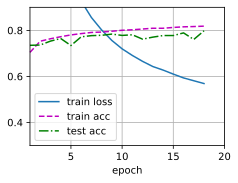

In [ ]:
num_epochs, lr = 20, 0.1

updater = torch.optim.SGD(params, lr=lr)

train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)